This notebook will be used to create biochem open boundary conditions, starting with SJDF, for full domain. 

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import math

# database stuff:
import sqlalchemy
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, ForeignKey, case
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import glob
import re
import gsw

%matplotlib inline

N2chl=1.600

# Load 3D T+S


In [2]:
# define constant values, not yet based on data:
val_bSi=7.74709546875e-06
val_DIA=1e-8
val_CRY=1e-8
val_MYRI=1e-8
val_MICZ=1e-8
val_Oxy = 160.0

In [3]:
TS = nc.Dataset('/data/dlatorne/MEOPAR/nowcast-green/open_boundaries/west/SalishSea_west_TEOS10.nc')

In [4]:
s=''
for key in TS.variables.keys():
    s=s+key+', '
print(s)

deptht, nav_lat, nav_lon, nbidta, nbjdta, nbrdta, time_counter, vosaline, votemper, 


In [5]:
print(TS.dimensions)

OrderedDict([('deptht', <class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40
), ('yb', <class 'netCDF4._netCDF4.Dimension'>: name = 'yb', size = 1
), ('xbT', <class 'netCDF4._netCDF4.Dimension'>: name = 'xbT', size = 870
), ('time_counter', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 52
)])


In [6]:
for key in TS.variables.keys():
    print(key, np.shape(TS.variables[key]))

deptht (40,)
nav_lat (1, 870)
nav_lon (1, 870)
nbidta (1, 870)
nbjdta (1, 870)
nbrdta (1, 870)
time_counter (52,)
vosaline (52, 40, 1, 870)
votemper (52, 40, 1, 870)


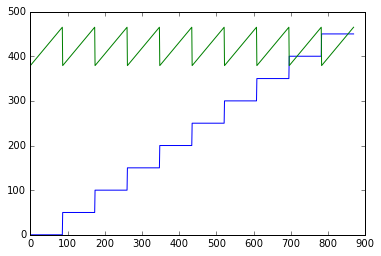

In [7]:
plt.plot(TS.variables['nbidta'][0,:]*50)
plt.plot(TS.variables['nbjdta'][0,:])

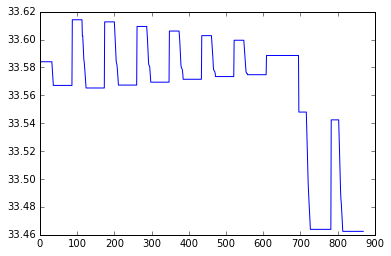

In [8]:
plt.plot(TS.variables['vosaline'][5,30,0,:])

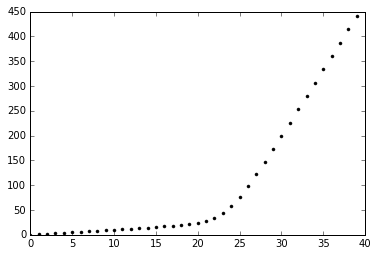

In [9]:
plt.plot(TS.variables['deptht'],'k.')

#Save to netcdf

In [10]:
new = nc.Dataset('/ocean/eolson/MEOPAR/NEMO-3.6-inputs/boundary_conditions/bioOBC_full.nc', 'w', zlib=True)
#Copy dimensions
for dname, the_dim in TS.dimensions.items():
    #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
    new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)

In [11]:
# create dimension variables:
# deptht
deptht=new.createVariable('deptht','float32',('deptht',))
deptht.long_name = 'Vertical T Levels'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))
deptht[:]=TS.variables['deptht']

#nav_lat
nav_lat = new.createVariable('nav_lat','float32',('yb','xbT'))
nav_lat.long_name = TS.variables['nav_lat'].long_name
nav_lat.units = TS.variables['nav_lat'].units
nav_lat[:] = TS.variables['nav_lat']

#nav_lon
nav_lon = new.createVariable('nav_lon','float32',('yb','xbT'))
nav_lon.long_name = TS.variables['nav_lon'].long_name
nav_lon.units = TS.variables['nav_lon'].units
nav_lon[:]=TS.variables['nav_lon']

# nbidta
nbidta=new.createVariable('nbidta','int32',('yb','xbT'))
nbidta.long_name = TS.variables['nbidta'].long_name
nbidta.units = TS.variables['nbidta'].units
nbidta[:]=TS.variables['nbidta']

# nbjdta
nbjdta=new.createVariable('nbjdta','int32',('yb','xbT'))
nbjdta.long_name = TS.variables['nbjdta'].long_name
nbjdta.units = TS.variables['nbjdta'].units
nbjdta[:]=TS.variables['nbjdta']

# nbrdta
nbrdta=new.createVariable('nbrdta','int32',('yb','xbT'))
nbrdta.long_name = TS.variables['nbrdta'].long_name
nbrdta.units = TS.variables['nbrdta'].units
nbrdta[:]=TS.variables['nbrdta']

# time_counter
time_counter = new.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
time_counter.axis = 'T'
time_counter.units = 'weeks since beginning of year'
time_counter[:]=TS.variables['time_counter']

In [12]:
print(TS.variables['vosaline'])

<class 'netCDF4._netCDF4.Variable'>
float32 vosaline(time_counter, deptht, yb, xbT)
    coordinates: nav_lon nav_lat deptht time_counter
    grid: SalishSea
    units: g/kg
    long_name: Reference Salinity
unlimited dimensions: time_counter
current shape = (52, 40, 1, 870)
filling on, default _FillValue of 9.969209968386869e+36 used



In [13]:
# variables
#NO3, Si, NH4, PHY, PHY2, MYRI, MICZ, POC, DOC, bSi

# NO3
voNO3 = new.createVariable('NO3', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voNO3.grid = TS.variables['votemper'].grid
voNO3.units = 'muM'
voNO3.long_name = 'Nitrate' 
# don't yet set values

#Si
voSi = new.createVariable('Si', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voSi.grid = TS.variables['votemper'].grid
voSi.units = 'muM'
voSi.long_name = 'Silica' 
# don't yet set values

#NH4
voNH4 = new.createVariable('NH4', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voNH4.grid = TS.variables['votemper'].grid
voNH4.units = 'muM'
voNH4.long_name = 'Ammonia' 
# don't yet set values

#DIA
voDIA = new.createVariable('DIA', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voDIA.units = 'muM N'
voDIA.long_name = 'Diatoms'
voDIA.grid = TS.variables['votemper'].grid
voDIA[:]=val_DIA

#CRY
voCRY = new.createVariable('CRY', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voCRY.units = 'muM N'
voCRY.long_name = 'Cryptophytes'
voCRY.grid = TS.variables['votemper'].grid
voCRY[:]=val_CRY

#MYRI
voMYRI = new.createVariable('MYRI', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voMYRI.units = 'muM N'
voMYRI.long_name = 'M. rubra' 
voMYRI.grid = TS.variables['votemper'].grid
voMYRI[:]=val_MYRI

#MICZ
voMICZ = new.createVariable('MICZ', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voMICZ.units = 'muM N'
voMICZ.long_name = 'Microzooplankton' 
voMICZ.grid = TS.variables['votemper'].grid
voMICZ[:]=val_MICZ

#PON
voPON = new.createVariable('PON', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voPON.units = 'muM N'
voPON.long_name = 'Particulate Organic Nitrogen'
voPON.grid = TS.variables['votemper'].grid
#voPON[:] = val_PON

#DON
voDON = new.createVariable('DON', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voDON.units = 'muM N'
voDON.long_name = 'Dissolved Organic Nitrogen'
voDON.grid = TS.variables['votemper'].grid
#voDON[:]=DON_val

#bSi
vobSi = new.createVariable('bSi', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
vobSi.units = 'muM N'
vobSi.long_name = 'Biogenic Silica'
vobSi.grid = TS.variables['votemper'].grid
vobSi[:]=val_bSi

#O2
voO2 = new.createVariable('O2', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
#voO2.units = ''
voO2.long_name = 'oxygen'
voO2.grid = TS.variables['votemper'].grid
voO2[:]=val_Oxy


# load database for data-based conditions

In [14]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'

# engine and reflection
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
Base.prepare(engine, reflect=True)
Station=Base.classes.StationTBL
Obs=Base.classes.ObsTBL
JDFLocs=Base.classes.JDFLocsTBL
Calcs=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

# column definitions
SA=case([(Calcs.Salinity_Bottle_SA!=None, Calcs.Salinity_Bottle_SA)], else_=
         case([(Calcs.Salinity_T0_C0_SA!=None, Calcs.Salinity_T0_C0_SA)], else_=
         case([(Calcs.Salinity_T1_C1_SA!=None, Calcs.Salinity_T1_C1_SA)], else_=
         case([(Calcs.Salinity_SA!=None, Calcs.Salinity_SA)], else_=
         case([(Calcs.Salinity__Unknown_SA!=None, Calcs.Salinity__Unknown_SA)], else_=Calcs.Salinity__Pre1978_SA)
        ))))
NO=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite)], else_=Obs.Nitrate)
NOUnits=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite_units)], else_=Obs.Nitrate_units)
NOFlag=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Flag_Nitrate_plus_Nitrite)], else_=Obs.Flag_Nitrate)
# Obs.Quality_Flag_Nitr does not match any nitrate obs
# ISUS not included in this NO
Tem=case([(Obs.Temperature!=None, Obs.Temperature)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary)], else_=Obs.Temperature_Reversing)))
TemUnits=case([(Obs.Temperature!=None, Obs.Temperature_units)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary_units)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary_units)], 
              else_=Obs.Temperature_Reversing_units)))
TemFlag=Obs.Quality_Flag_Temp
Ox=case([(Calcs.Oxygen_umolL!=None, Calcs.Oxygen_umolL)], else_=Calcs.Oxygen_Dissolved_umolL)
OxFlag=case([(Calcs.Oxygen_umolL!=None, Obs.Quality_Flag_Oxyg)], else_=Obs.Flag_Oxygen_Dissolved)
Press=case([(Obs.Pressure!=None, Obs.Pressure)], else_=Obs.Pressure_Reversing)

Ammonium:

In [15]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,
                Obs.Ammonium,Obs.Ammonium_units,Tem,SA).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(Obs.Ammonium!=None).\
        all()
qYr=[]
qMn=[]
qP=[]
qNH=[]
qTC=[]
qSA=[]
remP=[]
remNH=[]
for OID, Yr, Mn, P, NH, un, T, S_A in q:
    # throw out 1 data point that seems unusually high
    if not (P>75 and NH >.2):
        qYr.append(Yr)
        qMn.append(Mn)
        qP.append(P)
        qNH.append(NH)
        qTC.append(gsw.CT_from_t(S_A,T,P))
        qSA.append(S_A)
    else:
        remP.append(P)
        remNH.append(NH)

qYR=np.array(qYr)
qMn=np.array(qMn)
qP=np.array(qP)
qNH=np.array(qNH)
qTC=np.array(qTC)
qSA=np.array(qSA)
remP=np.array(remP)
remNH=np.array(remNH)

In [16]:
def ginterp(xval,xPeriod,yval,L,xlocs):
    # if not periodic, xPeriod=0
    fil=np.empty(np.size(xlocs))
    s=L/2.355
    for ii in range(0,xlocs.size):
        t=xlocs[ii]
        diff=[min(abs(x-t),abs(x-t+xPeriod), abs(x-t-xPeriod)) for x in xval]
        weight=[np.exp(-.5*x**2/s**2) if sum(diff<x)<2 or x < 5 else 0.0 for x in diff]
        #weight=[np.exp(-.5*x**2/s**2) for x in diff]
        weight=np.array(weight)
        fil[ii]=np.sum(weight*yval)/np.sum(weight)
    return(fil)

/home/eolson/anaconda3/envs/teos10/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


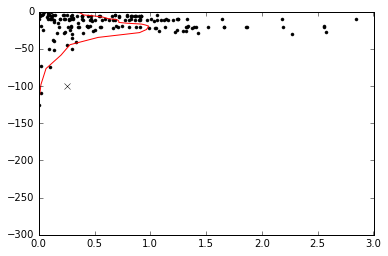

In [17]:
# create depth-weighted mean profile using gaussian filter
zs=np.array(TS.variables['deptht'])
plt.plot(qNH,-qP,'k.')
AmmProf=ginterp(qP,0.0,qNH,10,zs)
plt.plot(AmmProf,-zs,'r-')
plt.plot(remNH,-remP,'kx')

In [18]:
print(AmmProf)
AmmProf[-8:]=0.0
print(AmmProf)

[  2.40456999e-01   3.65887268e-01   3.80282366e-01   3.91473923e-01
   4.02102010e-01   4.72358355e-01   5.32753271e-01   5.76648563e-01
   6.02842811e-01   6.23594502e-01   6.90073188e-01   7.10733771e-01
   7.16317072e-01   7.18048435e-01   7.18102838e-01   7.93362081e-01
   9.21861668e-01   9.56219007e-01   9.84826763e-01   9.77881992e-01
   9.65514772e-01   9.03794283e-01   5.32465197e-01   2.79960873e-01
   1.99978086e-01   6.54793857e-02   2.00010468e-02   3.22206290e-04
   2.69354263e-14   1.05868317e-24   2.79170315e-35   5.96392394e-46
   1.14178278e-56   0.00000000e+00              nan              nan
              nan              nan              nan              nan]
[  2.40456999e-01   3.65887268e-01   3.80282366e-01   3.91473923e-01
   4.02102010e-01   4.72358355e-01   5.32753271e-01   5.76648563e-01
   6.02842811e-01   6.23594502e-01   6.90073188e-01   7.10733771e-01
   7.16317072e-01   7.18048435e-01   7.18102838e-01   7.93362081e-01
   9.21861668e-01   9.56219007e-0

In [19]:
for ii in range(0,zs.size):
    voNH4[:,ii,0,:]=AmmProf[ii]

In [20]:
voNH4[0,:,0,0]

array([  2.40456998e-01,   3.65887254e-01,   3.80282372e-01,
         3.91473919e-01,   4.02102023e-01,   4.72358346e-01,
         5.32753289e-01,   5.76648533e-01,   6.02842808e-01,
         6.23594522e-01,   6.90073192e-01,   7.10733771e-01,
         7.16317058e-01,   7.18048453e-01,   7.18102813e-01,
         7.93362081e-01,   9.21861649e-01,   9.56219018e-01,
         9.84826744e-01,   9.77881968e-01,   9.65514779e-01,
         9.03794289e-01,   5.32465219e-01,   2.79960871e-01,
         1.99978083e-01,   6.54793829e-02,   2.00010464e-02,
         3.22206295e-04,   2.69354258e-14,   1.05868319e-24,
         2.79170323e-35,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00], dtype=float32)

DON

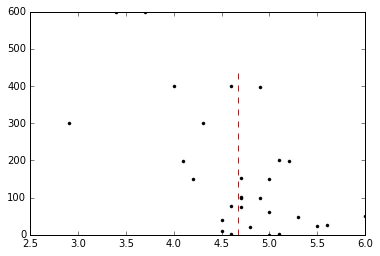

In [21]:
# take nearest available data to SJDF
q=session.query(Station.StartYear,Station.StartMonth,Press, Station.Lat, Station.Lon,Obs.Depth,
                Obs.Nitrogen_Dissolved_Organic,Obs.Nitrogen_Dissolved_Organic_units,Tem).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Nitrogen_Dissolved_Organic!=None).filter(Obs.Nitrogen_Dissolved_Organic>=0).\
        filter(Station.Lat!=None).filter(Station.Lon!=None).\
        filter(Station.Lat<48.8).filter(Station.Lon<-125).all()

qDON=[]
for row in q:
    qDON.append(row[6])
    plt.plot(row[6],row[2],'k.')
val_DON=np.mean(qDON)
plt.plot((val_DON,val_DON),(0,450),'r--')

In [22]:
voDON[:,:,:,:]=val_DON

PON

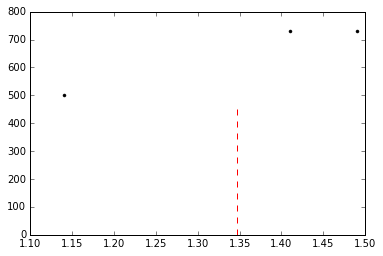

In [23]:
# take nearest available data to SJDF
q=session.query(Station.StartYear,Station.StartMonth,Press, Station.Lat, Station.Lon,Obs.Depth,
                Obs.Nitrogen_Particulate_Organic,Obs.Nitrogen_Particulate_Organic_units,Tem).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Nitrogen_Particulate_Organic!=None).filter(Obs.Nitrogen_Particulate_Organic>=0).\
        filter(Station.Lat!=None).filter(Station.Lon!=None).\
        filter(Station.Lat<48.8).filter(Station.Lon<-125).all()

qPON=[]
for row in q:
    qPON.append(row[6])
    plt.plot(row[6],row[2],'k.')
val_PON=np.mean(qPON)
plt.plot((val_PON,val_PON),(0,450),'r--')

In [24]:
voPON[:,:,:,:]=val_PON

NO3:

In [25]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,
                NO,NOUnits,Tem,SA, func.count()).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(NO!=None).group_by(NOUnits).\
        all()
for row in q:
    print(row)

(80451, 1971.0, 6.0, None, 19.4, 'mmol/m**3', 7.1, None, 209)
(60308, 2000.0, 8.0, 208.4, 34.5, 'umol/L', 6.9444, 34.07842114607245, 2610)


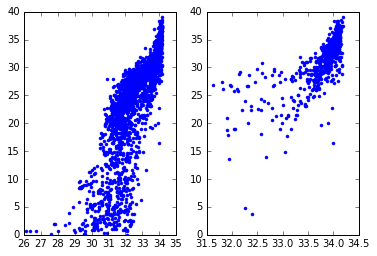

In [26]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,NO,Tem,SA,Station.StartDay).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(NO!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

qYr=[]
qMn=[]
qDy=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
date=[]
for OID, Yr, Mn, P, NO3, T, S_A, dy in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qDy.append(dy)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)

qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
date=np.array(date)
YD=0.0*qTC
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

qNO50=np.array(qNO50)

fig,axs=plt.subplots(1,2)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')

-4.55188235217 2.15074816221 -7.90228822138


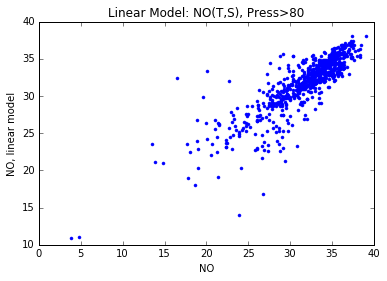

In [27]:
a=np.vstack([qTC50,qSA50,np.ones(len(qTC50))]).T
a2=np.vstack([qTC,qSA,np.ones(len(qTC))]).T
m = np.linalg.lstsq(a,qNO50)[0]
mT, mS, mC = m
print(mT, mS, mC)
plt.plot(qNO50,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((qNO50-np.dot(a,m)),(qNO50-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S), Press>80')


In [28]:
print(TS.variables['votemper'])

<class 'netCDF4._netCDF4.Variable'>
float32 votemper(time_counter, deptht, yb, xbT)
    units: degC
    long_name: Temperature
    coordinates: nav_lon nav_lat deptht time_counter
    grid: SalishSea
unlimited dimensions: time_counter
current shape = (52, 40, 1, 870)
filling on, default _FillValue of 9.969209968386869e+36 used



In [29]:
zupper=np.extract(zs<100, zs)
print(zupper)
ydays=np.arange(0,365,365/52)
print(ydays)
print(ydays.size)

[  0.5000003    1.5000031    2.50001144   3.50003052   4.50007057
   5.50015068   6.50031042   7.50062323   8.50123596   9.50243282
  10.50476551  11.50931168  12.51816654  13.53541183  14.56898212
  15.63428783  16.76117325  18.00713539  19.48178482  21.38997841
  24.10025597  28.22991562  34.68575668  44.51772308  58.48433304
  76.58558655  98.06295776]
[   0.            7.01923077   14.03846154   21.05769231   28.07692308
   35.09615385   42.11538462   49.13461538   56.15384615   63.17307692
   70.19230769   77.21153846   84.23076923   91.25         98.26923077
  105.28846154  112.30769231  119.32692308  126.34615385  133.36538462
  140.38461538  147.40384615  154.42307692  161.44230769  168.46153846
  175.48076923  182.5         189.51923077  196.53846154  203.55769231
  210.57692308  217.59615385  224.61538462  231.63461538  238.65384615
  245.67307692  252.69230769  259.71153846  266.73076923  273.75
  280.76923077  287.78846154  294.80769231  301.82692308  308.84615385
  315.865

In [30]:
def ginterp2d(xval,xPeriod,yval,yPeriod,zval,L,M,zlocs_x,zlocs_y):
    # if not periodic, xPeriod=0
    #fil=np.empty(np.size(xlocs))
    s=L/2.355
    n=M/2.355
    sdict={}
    mat=np.empty((np.size(zlocs_x),np.size(zlocs_y)))
    for ii in range(0,zlocs_x.size):
        print(ii)
        for jj in range(0,zlocs_y.size):
            tx=zlocs_x[ii]
            ty=zlocs_y[jj]
            diffx=[min(abs(x-tx),abs(x-tx+xPeriod), abs(x-tx-xPeriod)) for x in xval]
            diffy=[min(abs(y-ty),abs(y-ty+yPeriod), abs(y-ty-yPeriod)) for y in yval]
            weight=[np.exp(-.5*(x**2+y**2)/(s**2+n**2)) if \
                    (sum(diffx<x)<3 or x < L) and (sum(diffy<y)<3 or y < M) \
                    else 0.0 for x, y in zip(diffx, diffy)]
            #weight=[np.exp(-.5*x**2/s**2) for x in diff]
            weight=np.array(weight)
            sdict[(tx,ty)]=np.sum(weight*zval)/np.sum(weight)
            mat[ii,jj]=np.sum(weight*zval)/np.sum(weight)
    return(sdict,mat)

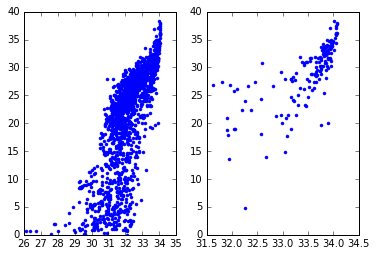

In [31]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,NO,Tem,SA,Station.StartDay).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(NO!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press<120).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

qYr=[]
qMn=[]
qDy=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
date=[]
for OID, Yr, Mn, P, NO3, T, S_A, dy in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qDy.append(dy)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)

qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
date=np.array(date)
YD=0.0*qTC
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

qNO50=np.array(qNO50)

fig,axs=plt.subplots(1,2)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')

In [32]:
ndict,nmat=ginterp2d(YD,365,qP,0,qNO,30,10,ydays,zupper)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


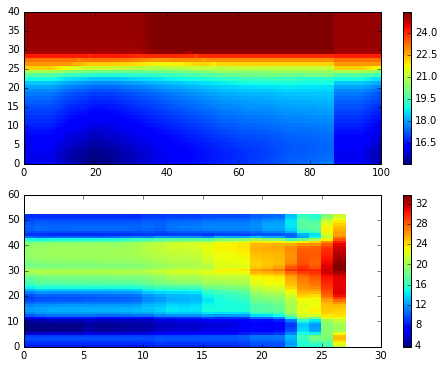

In [33]:
fig, axs = plt.subplots(2,1,figsize=(8,6))

mesh0=axs[0].pcolormesh(mC +mT*TS.variables['votemper'][5,:,0,0:100]+mS*TS.variables['vosaline'][5,:,0,0:100])
cb0=fig.colorbar(mesh0,ax=axs[0])

mesh1=axs[1].pcolormesh(nmat)
cb1=fig.colorbar(mesh1,ax=axs[1])

In [34]:
import math
ztan=[math.tanh((a-75)/10) for a in zupper]
zcoeff=np.ones(np.shape(TS.variables['votemper'])) # zcoeff is multiplier of fit function; 1-zcoeff is multiplier of climatology
for i in np.arange(0,zupper.size):
    zcoeff[:,i,:,:]=ztan[i]
funfit=mC +mT*TS.variables['votemper'][:,:,:,:]+mS*TS.variables['vosaline'][:,:,:,:]


In [35]:
nmat_2=np.expand_dims(nmat,axis=2)
nmat_2=np.expand_dims(nmat_2,axis=3)
nmat_3=np.tile(nmat_2,(1,1,1,TS.variables['votemper'].shape[3]))
clim=np.zeros(TS.variables['votemper'].shape)
clim[:,0:27,:,:]=nmat_3
print(clim.shape)

(52, 40, 1, 870)


In [36]:
voNO3[:,:,:,:]=zcoeff*funfit+(1-zcoeff)*clim

Si

In [37]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,
                Obs.Silicate,Obs.Silicate_units,Tem,SA,func.count()).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(Obs.Silicate!=None).group_by(Obs.Silicate_units).\
        all()
for row in q:
    print(row)

(80451, 1971.0, 6.0, None, 46.0, 'mmol/m**3', 7.1, None, 220)
(60308, 2000.0, 8.0, 208.4, 53.1, 'umol/L', 6.9444, 34.07842114607245, 2628)


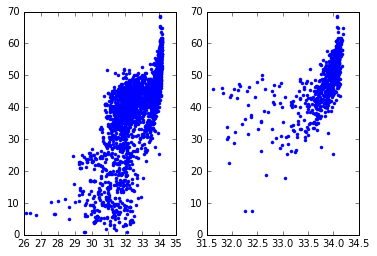

In [38]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,Obs.Silicate,Tem,SA,Station.StartDay).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(Obs.Silicate!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

qYr=[]
qMn=[]
qDy=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
date=[]
for OID, Yr, Mn, P, NO3, T, S_A, dy in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qDy.append(dy)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)

qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
date=np.array(date)
YD=0.0*qTC
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

qNO50=np.array(qNO50)

fig,axs=plt.subplots(1,2)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')

-10.7173052585 -0.610077830148 146.678340513


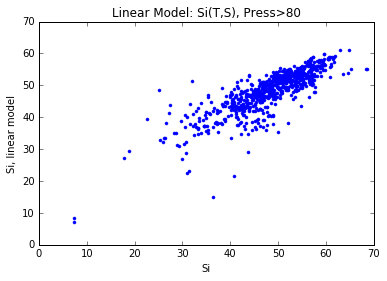

In [39]:
a=np.vstack([qTC50,qSA50,np.ones(len(qTC50))]).T
a2=np.vstack([qTC,qSA,np.ones(len(qTC))]).T
m = np.linalg.lstsq(a,qNO50)[0]
mT, mS, mC = m
print(mT, mS, mC)
plt.plot(qNO50,np.dot(a,m),'.')
plt.xlabel('Si')
plt.ylabel('Si, linear model')
SSE=np.dot((qNO50-np.dot(a,m)),(qNO50-np.dot(a,m)).T)
plt.title('Linear Model: Si(T,S), Press>80')

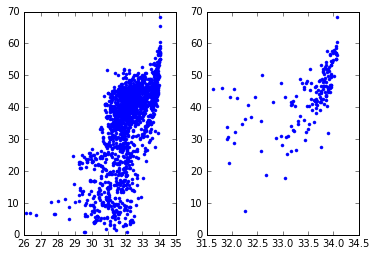

In [40]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,Obs.Silicate,Tem,SA,Station.StartDay).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(Obs.Silicate!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press<120).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

qYr=[]
qMn=[]
qDy=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
date=[]
for OID, Yr, Mn, P, NO3, T, S_A, dy in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qDy.append(dy)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)

qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
date=np.array(date)
YD=0.0*qTC
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

qNO50=np.array(qNO50)

fig,axs=plt.subplots(1,2)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')

In [41]:
sidict,simat=ginterp2d(YD,365,qP,0,qNO,30,10,ydays,zupper)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


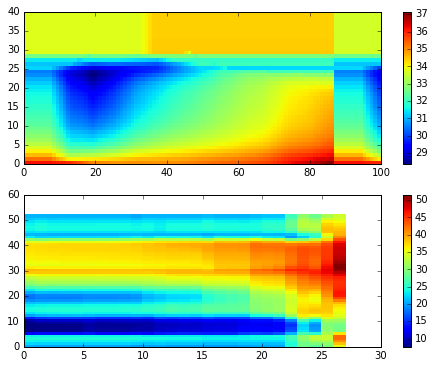

In [42]:
fig, axs = plt.subplots(2,1,figsize=(8,6))

mesh0=axs[0].pcolormesh(mC +mT*TS.variables['votemper'][5,:,0,0:100]+mS*TS.variables['vosaline'][5,:,0,0:100])
cb0=fig.colorbar(mesh0,ax=axs[0])

mesh1=axs[1].pcolormesh(simat)
cb1=fig.colorbar(mesh1,ax=axs[1])

In [43]:
funfit=mC +mT*TS.variables['votemper'][:,:,:,:]+mS*TS.variables['vosaline'][:,:,:,:]
simat_2=np.expand_dims(simat,axis=2)
simat_2=np.expand_dims(simat_2,axis=3)
simat_3=np.tile(simat_2,(1,1,1,TS.variables['votemper'].shape[3]))
clim=np.zeros(TS.variables['votemper'].shape)
clim[:,0:27,:,:]=simat_3
print(clim.shape)

(52, 40, 1, 870)


In [44]:
voSi[:,:,:,:]=zcoeff*funfit+(1-zcoeff)*clim

In [45]:
new.close()

In [46]:
TS.close()

# Northern OBCs:

In [47]:
TS = nc.Dataset('/data/dlatorne/MEOPAR/nowcast-green/open_boundaries/north/SalishSea_north_TEOS10.nc')

In [48]:
new = nc.Dataset('/ocean/eolson/MEOPAR/NEMO-3.6-inputs/boundary_conditions/bioOBC_full_north.nc', 'w', zlib=True)
#Copy dimensions
for dname, the_dim in TS.dimensions.items():
    #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
    new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)

In [49]:
# create dimension variables:
# deptht
deptht=new.createVariable('deptht','float32',('deptht',))
deptht.long_name = 'Vertical T Levels'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))
deptht[:]=TS.variables['deptht']

#nav_lat
nav_lat = new.createVariable('nav_lat','float32',('yb','xbT'))
nav_lat.long_name = TS.variables['nav_lat'].long_name
nav_lat.units = TS.variables['nav_lat'].units
nav_lat[:] = TS.variables['nav_lat']

#nav_lon
nav_lon = new.createVariable('nav_lon','float32',('yb','xbT'))
nav_lon.long_name = TS.variables['nav_lon'].long_name
nav_lon.units = TS.variables['nav_lon'].units
nav_lon[:]=TS.variables['nav_lon']

# nbidta
nbidta=new.createVariable('nbidta','int32',('yb','xbT'))
nbidta.long_name = TS.variables['nbidta'].long_name
nbidta.units = TS.variables['nbidta'].units
nbidta[:]=TS.variables['nbidta']

# nbjdta
nbjdta=new.createVariable('nbjdta','int32',('yb','xbT'))
nbjdta.long_name = TS.variables['nbjdta'].long_name
nbjdta.units = TS.variables['nbjdta'].units
nbjdta[:]=TS.variables['nbjdta']

# nbrdta
nbrdta=new.createVariable('nbrdta','int32',('yb','xbT'))
nbrdta.long_name = TS.variables['nbrdta'].long_name
nbrdta.units = TS.variables['nbrdta'].units
nbrdta[:]=TS.variables['nbrdta']

# time_counter
time_counter = new.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
time_counter.axis = 'T'
time_counter.units = 'weeks since beginning of year'
time_counter[:]=TS.variables['time_counter']

In [50]:
# variables
#NO3, Si, NH4, PHY, PHY2, MYRI, MICZ, POC, DOC, bSi

# NO3
voNO3 = new.createVariable('NO3', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voNO3.grid = TS.variables['votemper'].grid
voNO3.units = 'muM'
voNO3.long_name = 'Nitrate' 
# don't yet set values

#Si
voSi = new.createVariable('Si', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voSi.grid = TS.variables['votemper'].grid
voSi.units = 'muM'
voSi.long_name = 'Silica' 
# don't yet set values

#NH4
voNH4 = new.createVariable('NH4', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voNH4.grid = TS.variables['votemper'].grid
voNH4.units = 'muM'
voNH4.long_name = 'Ammonia' 
# don't yet set values

#DIA
voDIA = new.createVariable('DIA', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voDIA.units = 'muM N'
voDIA.long_name = 'Diatoms'
voDIA.grid = TS.variables['votemper'].grid
voDIA[:]=val_DIA

#CRY
voCRY = new.createVariable('CRY', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voCRY.units = 'muM N'
voCRY.long_name = 'Cryptophytes'
voCRY.grid = TS.variables['votemper'].grid
voCRY[:]=val_CRY

#MYRI
voMYRI = new.createVariable('MYRI', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voMYRI.units = 'muM N'
voMYRI.long_name = 'M. rubra' 
voMYRI.grid = TS.variables['votemper'].grid
voMYRI[:]=val_MYRI

#MICZ
voMICZ = new.createVariable('MICZ', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voMICZ.units = 'muM N'
voMICZ.long_name = 'Microzooplankton' 
voMICZ.grid = TS.variables['votemper'].grid
voMICZ[:]=val_MICZ

#PON
voPON = new.createVariable('PON', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voPON.units = 'muM N'
voPON.long_name = 'Particulate Organic Nitrogen'
voPON.grid = TS.variables['votemper'].grid
#voPON[:] = val_PON

#DON
voDON = new.createVariable('DON', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
voDON.units = 'muM N'
voDON.long_name = 'Dissolved Organic Nitrogen'
voDON.grid = TS.variables['votemper'].grid
#voDON[:]=DON_val

#bSi
vobSi = new.createVariable('bSi', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
vobSi.units = 'muM N'
vobSi.long_name = 'Biogenic Silica'
vobSi.grid = TS.variables['votemper'].grid
vobSi[:]=val_bSi

#O2
voO2 = new.createVariable('O2', 'float32', 
                               ('time_counter','deptht','yb','xbT'))
#voO2.units = ''
voO2.long_name = 'oxygen'
voO2.grid = TS.variables['votemper'].grid
voO2[:]=val_Oxy


In [51]:
for ii in range(0,zs.size):
    voNH4[:,ii,0,:]=AmmProf[ii]

In [52]:
voDON[:,:,:,:]=val_DON
voPON[:,:,:,:]=val_PON

-4.55188235217 2.15074816221 -7.90228822138


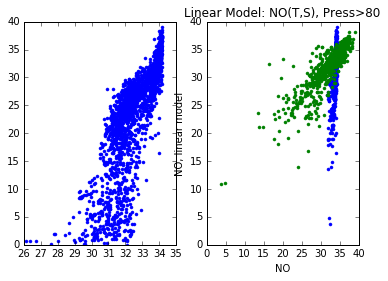

In [53]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,NO,Tem,SA,Station.StartDay).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(NO!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

qYr=[]
qMn=[]
qDy=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
date=[]
for OID, Yr, Mn, P, NO3, T, S_A, dy in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qDy.append(dy)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)

qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
date=np.array(date)
YD=0.0*qTC
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

qNO50=np.array(qNO50)

fig,axs=plt.subplots(1,2)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')
a=np.vstack([qTC50,qSA50,np.ones(len(qTC50))]).T
a2=np.vstack([qTC,qSA,np.ones(len(qTC))]).T
m = np.linalg.lstsq(a,qNO50)[0]
mT, mS, mC = m
print(mT, mS, mC)
plt.plot(qNO50,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((qNO50-np.dot(a,m)),(qNO50-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S), Press>80')


In [54]:

funfit=mC +mT*TS.variables['votemper'][:,:,:,:]+mS*TS.variables['vosaline'][:,:,:,:]
print(funfit.shape)

(2, 40, 1, 300)


In [55]:
nmat_2=np.expand_dims(nmat,axis=2)
nmat_2=np.expand_dims(nmat_2,axis=3)
nmat_3=np.tile(nmat_2,(1,1,1,TS.variables['votemper'].shape[3]))
clim=np.zeros(TS.variables['votemper'].shape)
clim[:,0:27,:,:]=nmat_3[0:2,:,:,:]
print(clim.shape)

(2, 40, 1, 300)


In [56]:
voNO3[:,:,:,:]=zcoeff[0:2,:,:,0:300]*funfit+(1-zcoeff[0:2,:,:,0:300])*clim

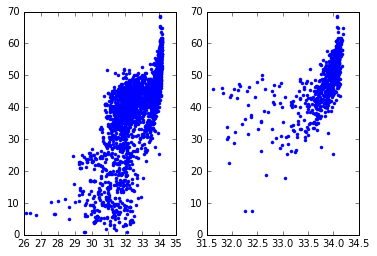

In [57]:
# umol/L=mmol/m**3, so all NO units the same
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press,Obs.Silicate,Tem,SA,Station.StartDay).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        join(Calcs,Calcs.ObsID==Obs.ID).filter(SA<38).filter(SA>0).filter(Obs.Silicate!=None).\
        filter(Tem!=None).filter(SA!=None).filter(Press!=None).\
        all()
#for row in q:
#    print(row)

qYr=[]
qMn=[]
qDy=[]
qP=[]
qNO=[]
qTC=[]
qSA=[]
qNO50=[]
qSA50=[]
qTC50=[]
date=[]
for OID, Yr, Mn, P, NO3, T, S_A, dy in q:
    qYr.append(Yr)
    qMn.append(Mn)
    qDy.append(dy)
    qP.append(P)
    qNO.append(NO3)
    qTC.append(gsw.CT_from_t(S_A,T,P))
    qSA.append(S_A)
    date.append(dt.date(int(Yr),int(Mn),int(dy)))
    if P>80:
        qNO50.append(NO3)
        qTC50.append(gsw.CT_from_t(S_A,T,P))
        qSA50.append(S_A)

qSA=np.array(qSA)
qTC=np.array(qTC)
qP=np.array(qP)
qNO=np.array(qNO)
qSA50=np.array(qSA50)
qTC50=np.array(qTC50)
date=np.array(date)
YD=0.0*qTC
for i in range(0,len(YD)):
    YD[i]=date[i].timetuple().tm_yday

qNO50=np.array(qNO50)

fig,axs=plt.subplots(1,2)
#plt.axis([28,35,0,40])
axs[0].plot(qSA,qNO,'.')
#axs[0].xlabel('Salinity')
#axs[0].ylabel('NO')
axs[1].plot(qSA50,qNO50,'.')
#axs[1].xlabel('Salinity')
#axs[1].ylabel('NO')

-10.7173052585 -0.610077830148 146.678340513


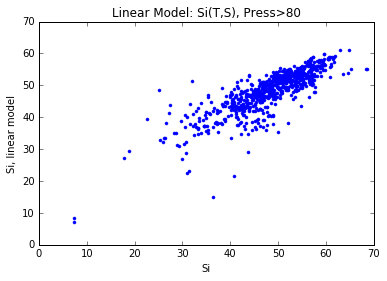

In [58]:
a=np.vstack([qTC50,qSA50,np.ones(len(qTC50))]).T
a2=np.vstack([qTC,qSA,np.ones(len(qTC))]).T
m = np.linalg.lstsq(a,qNO50)[0]
mT, mS, mC = m
print(mT, mS, mC)
plt.plot(qNO50,np.dot(a,m),'.')
plt.xlabel('Si')
plt.ylabel('Si, linear model')
SSE=np.dot((qNO50-np.dot(a,m)),(qNO50-np.dot(a,m)).T)
plt.title('Linear Model: Si(T,S), Press>80')

In [59]:
funfit=mC +mT*TS.variables['votemper'][:,:,:,:]+mS*TS.variables['vosaline'][:,:,:,:]
simat_2=np.expand_dims(simat,axis=2)
simat_2=np.expand_dims(simat_2,axis=3)
simat_3=np.tile(simat_2,(1,1,1,TS.variables['votemper'].shape[3]))
clim=np.zeros(TS.variables['votemper'].shape)
clim[:,0:27,:,:]=simat_3[0:2,:,:,:]
print(clim.shape)

(2, 40, 1, 300)


In [60]:
voSi[:,:,:,:]=zcoeff[0:2,:,:,0:300]*funfit+(1-zcoeff[0:2,:,:,0:300])*clim

In [61]:
for ik in new.variables.keys():
    print(np.max(new.variables[ik]),np.min(new.variables[ik]))

441.466 0.5
50.5038 50.413
-126.033 -126.219
61 32
896 887
9 0
1.0 0.0
29.9423 -9.08172
52.3194 -13.7677
0.984827 0.0
1e-08 1e-08
1e-08 1e-08
1e-08 1e-08
1e-08 1e-08
1.34667 1.34667
4.67586 4.67586
7.7471e-06 7.7471e-06
160.0 160.0


In [62]:
new.close()

In [63]:
TS.close()

In [64]:
test=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-3.6-inputs/boundary_conditions/bioOBC_full.nc')

In [65]:
print(test.variables['NH4'])
print(np.max(test.variables['NH4']))

<class 'netCDF4._netCDF4.Variable'>
float32 NH4(time_counter, deptht, yb, xbT)
    grid: SalishSea
    units: muM
    long_name: Ammonia
unlimited dimensions: time_counter
current shape = (52, 40, 1, 870)
filling on, default _FillValue of 9.969209968386869e+36 used

0.984827


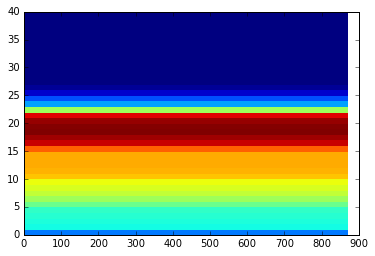

In [66]:
mesh0=plt.pcolormesh(test.variables['NH4'][0,:,0,:])

In [67]:
for ik in test.variables.keys():
    print(np.max(test.variables[ik]),np.min(test.variables[ik]))

441.466 0.5
48.7104 48.3507
-124.612 -124.946
9 0
465 379
9 0
52.0 1.0
44.3829 -10.3852
96.4887 -20.9073
0.984827 0.0
1e-08 1e-08
1e-08 1e-08
1e-08 1e-08
1e-08 1e-08
1.34667 1.34667
4.67586 4.67586
7.7471e-06 7.7471e-06
160.0 160.0


In [68]:
test.close()